### Creating a Convolutional Neural Network

In this notebook, we go through the process of building a convolutional neural network.

This notebook does not contain all the iterations that came before.

We started by first building a CNN that was massively overfit. Then we applied regularization in an attempt to control the loss. That worked great, but it also made the accuracy plummet to below 2%, including for the training set.

This notebook summarizes the process of fine tuning the CNN so that it can have some accuracy without having crazy loss.

Some cells and outputs are missing because of failing to transfer all the work done on Google Colab before getting the session shut down. However, it does focus on one model that performed better than most and how it was trained.

The next notebook focuses on gathering predictions from a trained model.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
import numpy as np
import os
import PIL
import PIL.Image
import shutil
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

In [27]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
tf.random.set_seed(42)

In [4]:
!mkdir kaggle_dataset


In [5]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/kaggle_dataset'

In [ ]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

In [7]:
!chmod 600 /content/kaggle_dataset/kaggle.json

In [8]:
!kaggle competitions download -c hotel-id-2021-fgvc8 --force

100% 24.4G/24.4G [05:10<00:00, 170MB/s]
100% 24.4G/24.4G [05:10<00:00, 84.4MB/s]


In [ ]:
!unzip hotel-id-2021-fgvc8.zip -d /content/kaggle_dataset/hotels/

In [10]:
train_df = pd.read_csv('/content/kaggle_dataset/hotels/train.csv')

In [11]:
train_df = train_df.drop_duplicates(subset=['image'], keep='first')

In [12]:
folders = [str(chain) for chain in range(0, 92)]
dir = "/content/kaggle_dataset/hotels/train_images/"
hotels_dir = f"/content/kaggle_dataset/hotels/train_images_by_id/"
for folder in folders:
  chain_path = dir + folder + '/'
  if os.path.exists(chain_path):
    for file in os.listdir(chain_path):
      if file.endswith('.jpg'):
        hotel_id = str(train_df[train_df['image'] == file]['hotel_id'].values[0])
        hotel_dir = hotels_dir + hotel_id
        if not os.path.exists(hotel_dir):
          os.makedirs(hotel_dir)
        if os.path.exists(hotel_dir):
          file_path = chain_path + file
          shutil.move(file_path, hotel_dir)


In [13]:
!mkdir /content/kaggle_dataset/hotels/batches

In [202]:
# moves from batches back to hotel ids
# handy for when you screw stuff up

# dir = '/content/kaggle_dataset/hotels/batches/'
# train_dir = '/content/kaggle_dataset/hotels/train_images_by_id/'
# for i in range(1, 15):
#   for root, dirs, files in os.walk(f'{dir}batch_{i}', topdown=False):
#     hotel_id = root.split('/')[-1]
#     destination = f'{train_dir}{hotel_id}'
#     for file in files:
#       file_path = root + '/' + file
#       shutil.move(file_path, destination)

In [14]:
# moves from hotel id folders to batches
dir = "/content/kaggle_dataset/hotels/train_images_by_id/"
batches_dir = "/content/kaggle_dataset/hotels/batches/"
id_count = 0
batch = 1
for root, dirs, files in os.walk(dir, topdown=False):
  id_count += 1
  batch_dir = f'batch_{batch}/'
  batch_directory = batches_dir + batch_dir
  if not os.path.exists(batch_directory):
    os.makedirs(batch_directory)
  if id_count <= 500:
  
    hotel_id = root.split('/')[-1]
    batch_hotel_dir = f'{batch_directory}{hotel_id}/' 
    if not os.path.exists(batch_hotel_dir):
      os.makedirs(batch_hotel_dir)
    if os.path.exists(batch_hotel_dir):
      for file in files:
        shutil.move(root + '/' + file, batch_hotel_dir)
  else:
    batch += 1
    id_count = 0

In [ ]:
batches_dir = "/content/kaggle_dataset/hotels/batches/batch_"
for i in range(1, 10):
  batch_dir = f'{batches_dir}{i}'
  print(len(os.listdir(batch_dir)))


In [16]:
def get_batchsets(batch_num):
  batch_size = 32
  img_height = 56
  img_width = 56
  hotels_dir = f"/content/kaggle_dataset/hotels/batches/batch_{batch_num}/"
  train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    hotels_dir,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    subset='training',
    validation_split=0.2,
    label_mode='int'
  )
  val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  hotels_dir,
  validation_split=0.2,
  subset='validation',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='int'
)
  return (train_ds, val_ds)

In [17]:
train_ds_b, val_ds_b = get_batchsets(1)
train_ds_b

Found 6115 files belonging to 500 classes.
Using 4892 files for training.
Found 6115 files belonging to 500 classes.
Using 1223 files for validation.


<BatchDataset shapes: ((None, 56, 56, 3), (None,)), types: (tf.float32, tf.int32)>

In [18]:
class_names = train_ds_b.class_names

In [20]:
def cache_ds(train_ds, val_ds):
  AUTOTUNE = tf.data.AUTOTUNE
  train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
  return(train_ds, val_ds)

In [24]:
train_ds_b, val_ds_b = cache_ds(train_ds_b, val_ds_b)

In [57]:
def show_images(image_ds, take=1):
  plt.figure(figsize=(10,10))
  for images, labels in image_ds.take(take):
    for i in range(9):
      ax = plt.subplot(3, 3, i+1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis('off')

View some images in our training set:

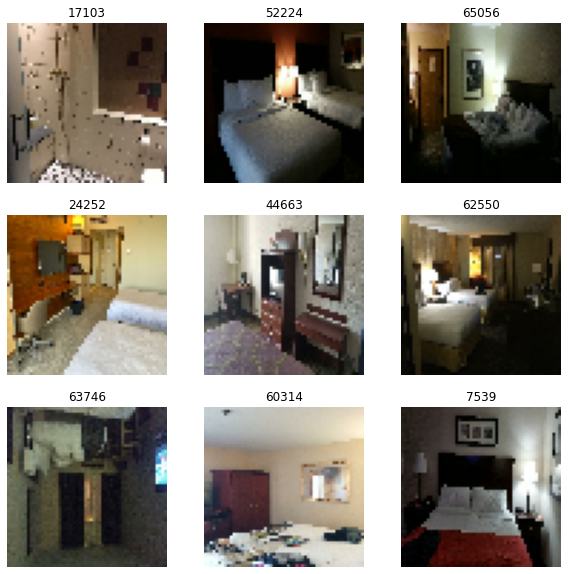

In [23]:
show_images(train_ds_b)

In [26]:
num_classes = len(class_names)
num_classes

500

### class ConvNet

This class can be used to instantiate models more quickly.

It also keeps track of the "best" model seen so far and the "best" accuracy.

In [40]:
class ConvNet:
  models = []
  best_model = None
  best_acc = 0
  """
  arguments:
  cFilters: list of tuples describing each conv2d layer (int filters, float l2 regularization)
  dLayers: list of tuples describing each dense layer (int nodes, float l2 regularization, float dropout)
  """
  def __init__(self, cFilters=[(64,0)], dLayers=[(800,0,0)]):
    self.hyperparameters = {
        'cFilters': cFilters,
        'dLayers': dLayers
    }
    self.create_model(cFilters, dLayers)
    
  def create_model(self, cFilters, dLayers):
    model = tf.keras.Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1./255))
    model.add(layers.experimental.preprocessing.RandomFlip('horizontal'))
    model.add(layers.experimental.preprocessing.RandomZoom(0.2))
    model.add(layers.experimental.preprocessing.RandomRotation(0.1))
    model.add(layers.experimental.preprocessing.CenterCrop(28, 28))
    for cFilter, reg in cFilters:
      model.add(layers.Conv2D(cFilter, 3, padding='same', activation='relu', kernel_regularizer=l2(reg)))
      model.add(layers.MaxPooling2D(padding='valid'))
    model.add(layers.Flatten())
    for dLayer, reg, drop in dLayers:
      model.add(layers.Dense(dLayer, activation='relu', kernel_regularizer=l2(reg)))
      model.add(layers.Dropout(drop))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(
      optimizer='adam',
      loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy'])
    self.model = model
  def fit(self, train_ds, val_ds, epochs=100, batch_size=16):
    history = self.model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size)
    best_acc = max(history.history['val_accuracy'])
    print('best acc', best_acc)
    if best_acc > ConvNet.best_acc:
      ConvNet.best_acc = best_acc
      ConvNet.best_model = self
    ConvNet.models.append(self.model)
    self.history = history
    return history



I'm not including all the outputs from these next cells because they're here to just show the process by which I used a shotgun approach to find a model that looked promising. It's sort of like my homemade GridSearch. In this notebook I focus on one model that performed better than most.

In [41]:
convNets = []
cLayers =[[(100, 0), (32, 0)], [(100, 1e-5), (32, 0)], [(64, 0), (32, 0)], [(100, 1e-5), (16, 0), (16, 0)]]
dLayers = [[(400, 0, 0.6), (200, 0, 0.6)], [(400, 1e-5, 0.6), (200, 0, 0.6)]]
for c in cLayers:
  for d in dLayers:
    convNets.append(ConvNet(c, d))

In [ ]:
for i, cn in enumerate(convNets):
  print('progress:', i, 'best:', ConvNet.best_acc )
  cn.fit(train_ds, val_ds, 1000)

In [201]:
ConvNet.best_acc

0.0735759511590004

In [49]:
history1 = convNets[0].fit(train_ds_b, val_ds_b)

Epoch 1/100
153/153 [==============================] - 1s 7ms/step - loss: 4.2857 - accuracy: 0.0959 - val_loss: 6.9761 - val_accuracy: 0.0736
Epoch 2/100
153/153 [==============================] - 1s 7ms/step - loss: 4.2526 - accuracy: 0.1030 - val_loss: 6.9408 - val_accuracy: 0.0720
Epoch 3/100
153/153 [==============================] - 1s 7ms/step - loss: 4.2458 - accuracy: 0.1024 - val_loss: 7.0085 - val_accuracy: 0.0760
Epoch 4/100
153/153 [==============================] - 1s 7ms/step - loss: 4.2832 - accuracy: 0.1092 - val_loss: 6.9682 - val_accuracy: 0.0703
Epoch 5/100
153/153 [==============================] - 1s 7ms/step - loss: 4.2730 - accuracy: 0.1026 - val_loss: 6.9262 - val_accuracy: 0.0760
Epoch 6/100
153/153 [==============================] - 1s 7ms/step - loss: 4.2425 - accuracy: 0.1049 - val_loss: 7.0435 - val_accuracy: 0.0744
Epoch 7/100
153/153 [==============================] - 1s 7ms/step - loss: 4.2886 - accuracy: 0.1120 - val_loss: 6.8945 - val_accuracy: 0.0769

In [44]:
def plot_history(history, epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')

### Plotting a journey of training

These plots serve as a time series of training a model that was pretty typical during our numerous numerous numerous iterations



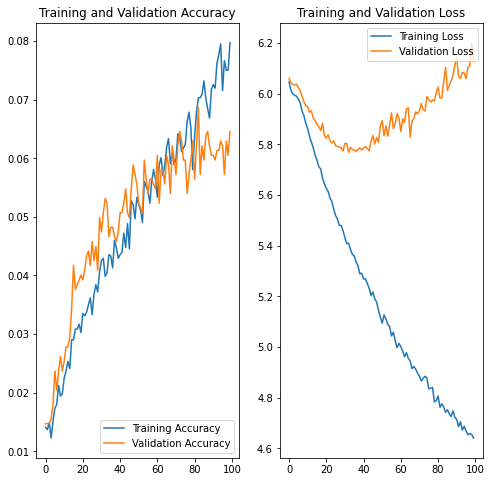

In [45]:
plot_history(history1, 100)

This model looks promising for a while during the first 100 epochs of training, but loss starts to creep up and accuracy starts to flatten out around 6%.



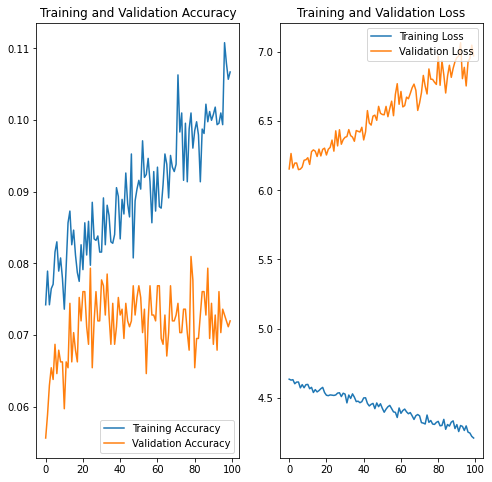

In [47]:
plot_history(history1, 100)

During the next 100 epochs of training, it looks like we've gotten all we can out of this model. The training set is continuing to learn, but the validation set has flattened out in accuracy. Meanwhile, loss for the training set is falling, but for the validation set it's climbing.

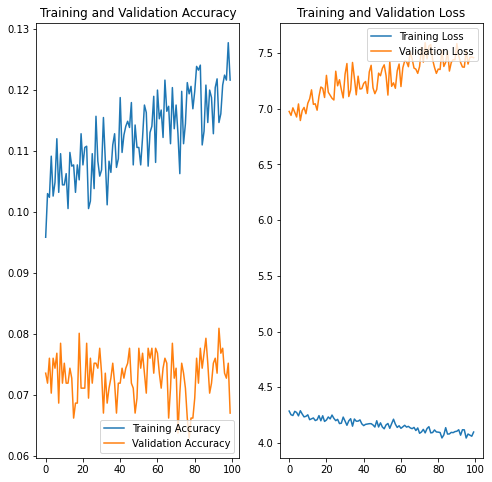

In [50]:
plot_history(history1, 100)

Just to be sure, we trained the model for another 100 epochs. It seems like this is the best it's going to get.

#### Final metrics: 

    Training loss:  4.0973
    Training accuracy: 0.1216
    Validation loss: 7.4586
    Validation accuracy: 0.0670

We'll cover testing predictions and getting the top five predictions in the next notebook.